In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### DATASET PREPROCESSING

In this dataset preprocessing we are basically merging target_cued.csv and target_uncued.csv across trials. And alfter this cleaning as per the question given 

In [2]:
base_dir = "D3-16"


In [3]:
emotions =  ['E1', 'E2', 'E3']
trials = ['1', '2']

### Merging code logic

For each participant in each emotion block across both 1 and 2 trials the code Merges all target_cued.csv files into a single file merged_target_cued.csv and same for target_uncued.csv into merged_target_uncued.csv

First it raeads and stores in cued_dfs and uncued_dfs then it merges the dataframes and writes it into merged_target_cued.csv merged_target_uncued.csv respectively

In [4]:
#First merging the data of queued and unqueued in 1 and 2 folder for each participant

def merge_csv_files(participant_folder, emotions, trials):
    cued_files = []
    uncued_files = []

    for block in emotions:
        block_path = os.path.join(participant_folder, block)

        if not os.path.exists(block_path):
            continue
        

        for subfolder in trials:
            trial_dir = os.path.join(block_path, subfolder)

            cued_file_path = os.path.join(trial_dir, "target_cued.csv")
            uncued_file_path = os.path.join(trial_dir, "target_uncued.csv")
            
            cued_files.append(cued_file_path)
            uncued_files.append(uncued_file_path)

        cued_dfs = []
        for file in cued_files:
            if os.path.exists(file):
                cued_dfs.append(pd.read_csv(file))
            else:
                print(f"Missing cued file: {file}")
                pass

        uncued_dfs = []
        for file in uncued_files:
            if os.path.exists(file):
                uncued_dfs.append(pd.read_csv(file))
            else:
                print(f"Missing uncued file: {file}")
                pass

        if cued_dfs:
            merged_cued = pd.concat(cued_dfs, ignore_index=True)
            a = os.path.join(block_path, "merged_target_cued.csv")
            merged_cued.to_csv(a, index=False)
        
        if uncued_dfs:
            merged_uncued = pd.concat(uncued_dfs, ignore_index=True)
            b = os.path.join(block_path, "merged_target_uncued.csv")
            merged_uncued.to_csv(b, index=False)


In [5]:
for participant in os.listdir(base_dir):
    participant_path = os.path.join(base_dir, participant)
    if os.path.isdir(participant_path):
        merge_csv_files(participant_path, emotions, trials)
    print("Merge completed for: ", participant)

print("Merging complete!")

Merge completed for:  ADB
Merge completed for:  ARV
Merge completed for:  ASL
Missing cued file: D3-16\ASR\E3\1\target_cued.csv
Missing uncued file: D3-16\ASR\E3\1\target_uncued.csv
Merge completed for:  ASR
Merge completed for:  AYA
Merge completed for:  JAT
Merge completed for:  NIH
Merge completed for:  PRA
Merge completed for:  TUS
Merge completed for:  UJW
Merging complete!


### Cleaning logic

This code drops all the columns named from t1 to t86. And removes the extra empty columns beyond the last column which has no nan value and then it saves cleaned_target_cued.csv and cleaned_target_uncued.csv in their respective emotion block.

In [6]:

for participant in os.listdir(base_dir):
    participant_path = os.path.join(base_dir, participant)
    # if not os.path.isdir(participant_path):
    #     continue

    if os.path.isdir(participant_path):

        for block in emotions:
            block_path = os.path.join(participant_path, block)
            if not os.path.exists(block_path):
                continue

            for filename in ["merged_target_cued.csv", "merged_target_uncued.csv"]:
                file_path = os.path.join(block_path, filename)
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)

                    # Droping the columns from t1 to t86 according to the question
                    t_columns_to_remove = []
                    for col in df.columns:
                        if col.startswith('t'):
                            suffix = col[1:]
                            if suffix.isdigit():
                                num = int(suffix)
                                if 1 <= num <= 86:
                                    t_columns_to_remove.append(col)
                    df.drop(columns=t_columns_to_remove, errors='ignore', inplace=True)

                    # Keeping the columns up to the last non-empty column
                    last_non_empty_index = df.notna().sum(axis=0).gt(0).cumsum().idxmax()
                    df = df.loc[:, :last_non_empty_index]

                    
                    cleaned_file_name = filename.replace("merged_", "cleaned_")
                    cleaned_path = os.path.join(block_path, cleaned_file_name)
                    
                    try:
                        df.to_csv(cleaned_path, index=False)
                    except Exception as save_err:
                        print(f"Failed to save cleaned file {cleaned_path}: {save_err}")


        print("Cleaned the file:", participant)

print("Cleaning complete!")


Cleaned the file: ADB
Cleaned the file: ARV
Cleaned the file: ASL
Cleaned the file: ASR
Cleaned the file: AYA
Cleaned the file: JAT
Cleaned the file: NIH
Cleaned the file: PRA
Cleaned the file: TUS
Cleaned the file: UJW
Cleaning complete!


### DATASET ANALYSIS

In this we are visualizing the distribution of trials. The plot shows the number of cued and uncued tirals for each participant with bar grouped by emotion blocks.

In [7]:
def load_and_merge_data(base_dir, emotions):
    all_data = []
    
    for participant in os.listdir(base_dir):
        participant_path = os.path.join(base_dir, participant)
        if not os.path.isdir(participant_path):
            continue
        
        for block in emotions:
            block_path = os.path.join(participant_path, block)
            for session in ['1', '2']:
                session_path = os.path.join(block_path, session)
                
                for condition, filename in [("cued", "target_cued.csv"), ("uncued", "target_uncued.csv")]:
                    file_path = os.path.join(session_path, filename)
                    if os.path.exists(file_path):
                        try:
                            df = pd.read_csv(file_path)
                        except:
                            print(f"Couldn't read file: {file_path} — {e}")
                            continue
                        df['condition'] = condition
                        df['block'] = block
                        df['participant'] = participant
                        all_data.append(df)

    return pd.concat(all_data, ignore_index=True) if all_data else None

In [8]:
df = load_and_merge_data(base_dir, emotions)

df_counts = df.groupby(['participant', 'block', 'condition']).size().reset_index(name='count')

df_cued = df_counts[df_counts['condition'] == 'cued']
df_uncued = df_counts[df_counts['condition'] == 'uncued']

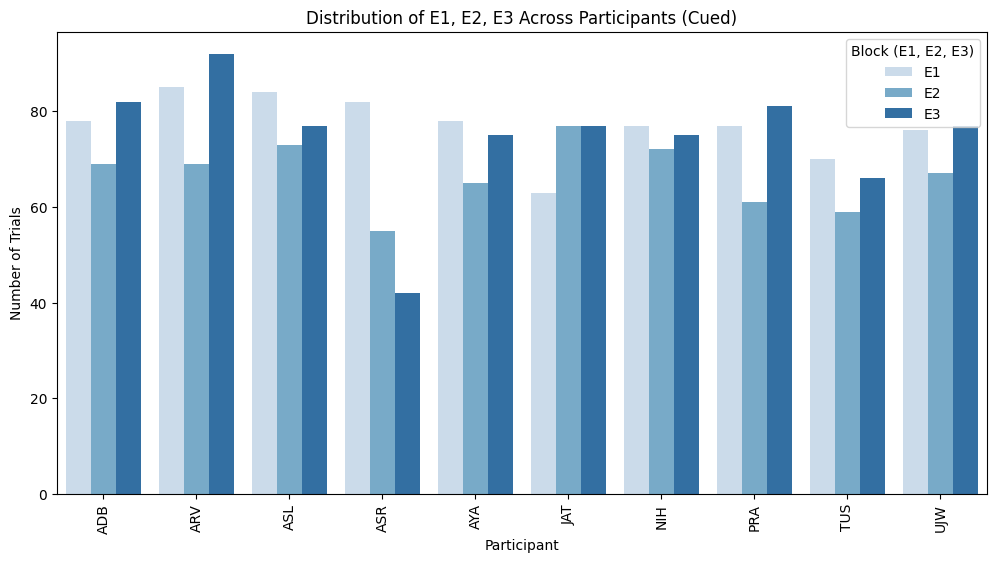

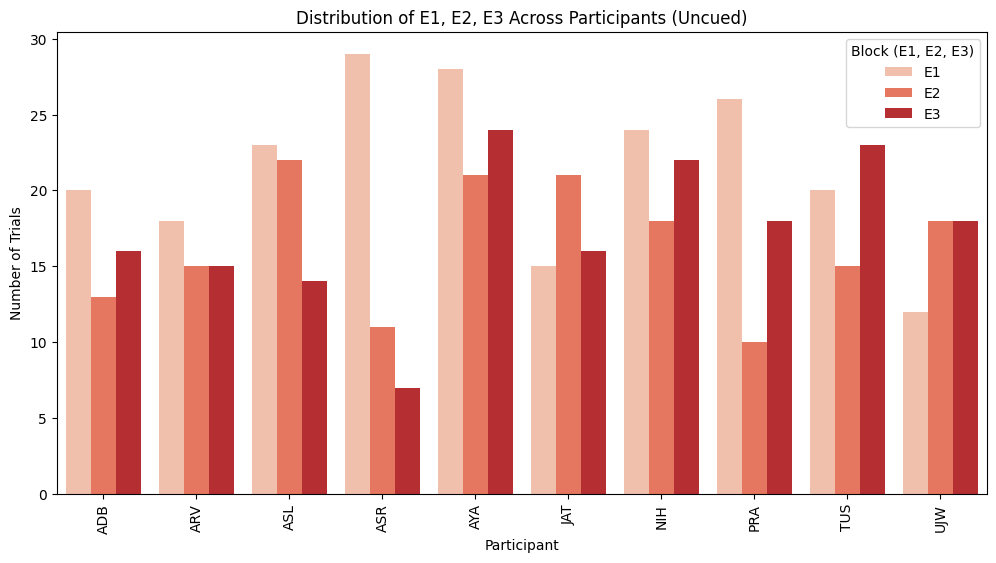

In [9]:

plt.figure(figsize=(12, 6))
sns.barplot(x='participant', y='count', hue='block', data=df_cued, palette="Blues", dodge=True)
plt.title("Distribution of E1, E2, E3 Across Participants (Cued)")
plt.xlabel("Participant")
plt.ylabel("Number of Trials")
plt.xticks(rotation=90)
plt.legend(title="Block (E1, E2, E3)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='participant', y='count', hue='block', data=df_uncued, palette="Reds", dodge=True)
plt.title("Distribution of E1, E2, E3 Across Participants (Uncued)")
plt.xlabel("Participant")
plt.ylabel("Number of Trials")
plt.xticks(rotation=90)
plt.legend(title="Block (E1, E2, E3)")
plt.show()


##### From here We are basically segeregating the data into 12 csv files for each emotion block for each ecentricity so that we can take averages correctly across participants and plot it in graph for 12 conditions. 

Now Dividing the data according to its ecentricities and putiing it into its respecting emotion block and  creating this for both cued and uncues by separatly creating the folders.

In [ ]:
cue_groups = {
    "0": [0.0],
    "4": [-4.0, 4.0],
    "8": [-8.0, 8.0],
    "16": [-16.0, 16.0]
}

for participant in os.listdir(base_dir):
    participant_path = os.path.join(base_dir, participant)

    if not os.path.isdir(participant_path):
        continue  

    for block in emotions:
        block_path = os.path.join(participant_path, block)

        cued_output_path = os.path.join(block_path, "cued")
        uncued_output_path = os.path.join(block_path, "uncued")

        os.makedirs(cued_output_path, exist_ok=True)
        os.makedirs(uncued_output_path, exist_ok=True)

        for file_name, output_dir in [
            ("cleaned_target_cued.csv", cued_output_path),
            ("cleaned_target_uncued.csv", uncued_output_path)
        ]:
            file_path = os.path.join(block_path, file_name)

            if not os.path.exists(file_path):
                continue

            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Couldn't read {file_path}: {e}")
                continue

            if 'cue_location' not in df.columns:
                print(f"'cue_location' column missing in {file_path}")
                continue

            for group_label, group_values in cue_groups.items():
                subset = df[df['cue_location'].isin(group_values)]

                out_file_name = f"{block}_{group_label}.csv"
                out_file_path = os.path.join(output_dir, out_file_name)

                subset.to_csv(out_file_path, index=False)

    print("Done for:", participant)

print("Merging, cleaning, and pupil analysis complete!")


Done for: ADB
Done for: ARV
Done for: ASL
Done for: ASR
Done for: AYA
Done for: JAT
Done for: NIH
Done for: PRA
Done for: TUS
Done for: UJW
Merging, cleaning, and pupil analysis complete!


#### After this we are taking the averages of each timeline of emotion_ecentrity of all participants for example taking E1_0 of all participants and taking average og each time line.  Doing this for all participants and storing it in a dictionary.

In [ ]:
averages = {"cued": {}, "uncued": {}}
    
for cue_type in ["cued", "uncued"]:

    for block in emotions:

        for group in ["0", "4", "8", "16"]:


            key = f"{block}_{group}"
            
            all_participant_means = []
            
            for participant in os.listdir(base_dir):
                participant_path = os.path.join(base_dir, participant)

                if not os.path.isdir(participant_path):
                    continue
                
                csv_path = os.path.join(participant_path, block, cue_type, f"{key}.csv")

                if os.path.exists(csv_path):
                    df = pd.read_csv(csv_path)
                    mean_series = df.mean(numeric_only=True)
                    all_participant_means.append(mean_series)
            
            if all_participant_means:
                df_of_means = pd.DataFrame(all_participant_means)
                final_mean = df_of_means.mean()
                averages[cue_type][key] = final_mean



In [12]:
averages

{'cued': {'E1_0': response_time    0.366846
  location         0.000000
  cue_location     0.000000
  t87              3.715474
  t88              3.707338
                     ...   
  t457             4.341513
  t458             4.499408
  t459             4.508927
  t460             4.517032
  t461             4.516464
  Length: 378, dtype: float64,
  'E1_4': response_time    0.518705
  location        -0.229611
  cue_location    -0.229611
  t87              3.731658
  t88              3.726674
                     ...   
  t457             4.808042
  t458             4.395633
  t459             4.392180
  t460             4.402087
  t461             3.945937
  Length: 378, dtype: float64,
  'E1_8': response_time    0.425509
  location        -0.691250
  cue_location    -0.691250
  t87              3.733075
  t88              3.726436
                     ...   
  t457             4.648334
  t458             4.626344
  t459             4.633365
  t460             4.621369
  t461    

In [13]:

def plot_pupil_diameter(averages, cue_type):
    plt.figure(figsize=(12, 8))
    
    for group in ["0", "4", "8", "16"]:
        plt.figure()
        for block in ['E1', 'E2', 'E3']:
            key = f"{block}_{group}"
            if key in averages[cue_type]:
                avg_values = averages[cue_type][key]
                time_points = [col for col in avg_values.index if col.startswith('t')]
                
                x_ticks = list(range(0, len(time_points), len(time_points) // 5))
                x_labels = [time_points[i] for i in x_ticks]
                
                plt.plot(time_points, avg_values[time_points], label=block)
                plt.xticks(x_ticks, x_labels, rotation=45)
        
        plt.xlabel("Time (selected intervals)")
        plt.ylabel("Average Pupil Diameter")
        plt.title(f"Average Pupil Diameter Over Time for Cue {group} ({cue_type.capitalize()})")
        plt.legend()
        plt.show()

Plotting the plots for each eccentricities for both cued and uncued for better visualization..

<Figure size 1200x800 with 0 Axes>

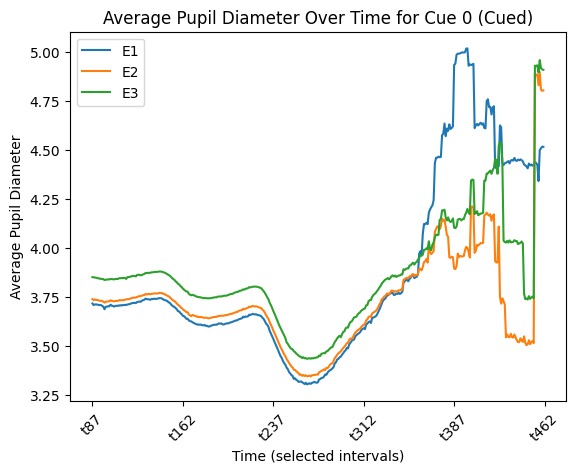

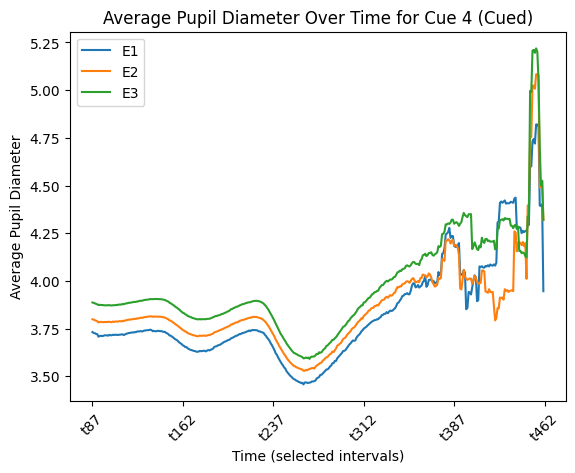

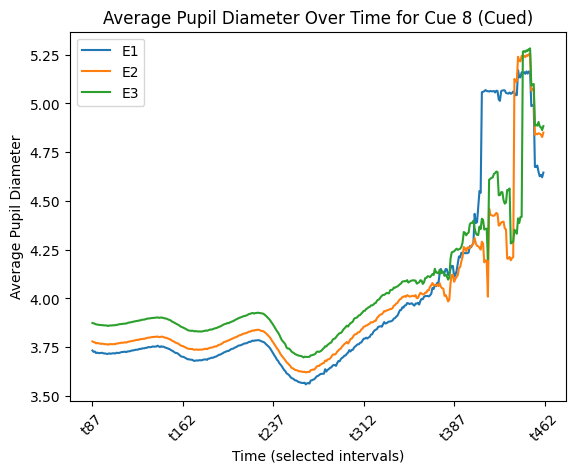

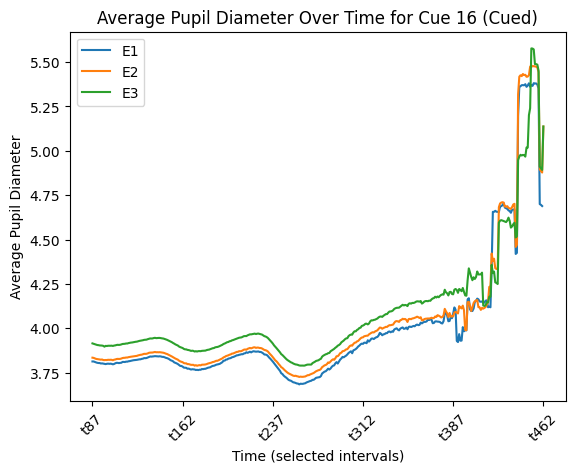

<Figure size 1200x800 with 0 Axes>

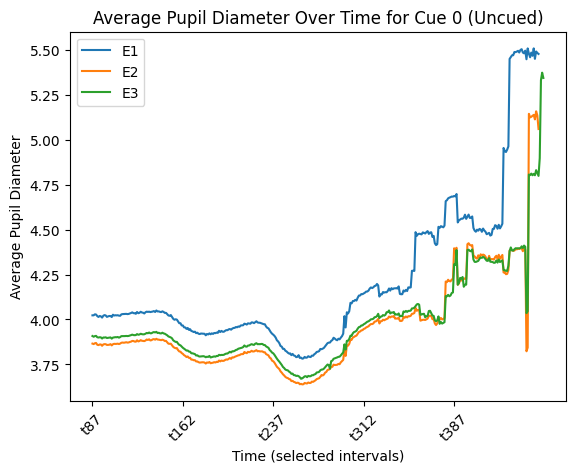

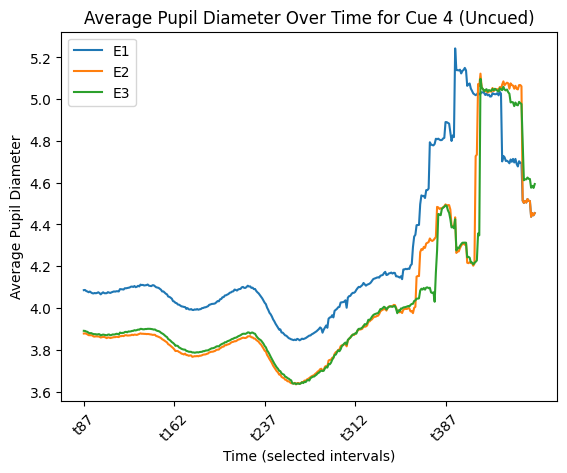

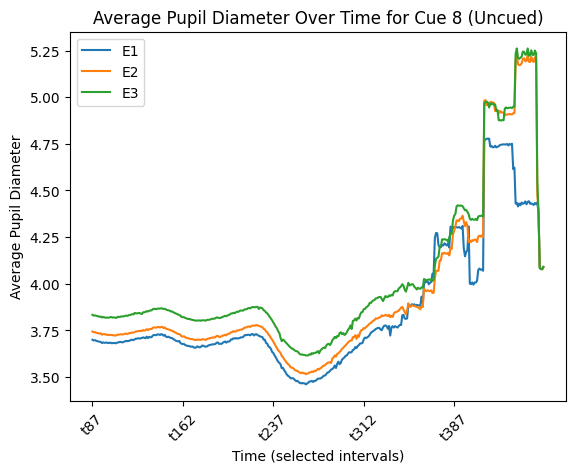

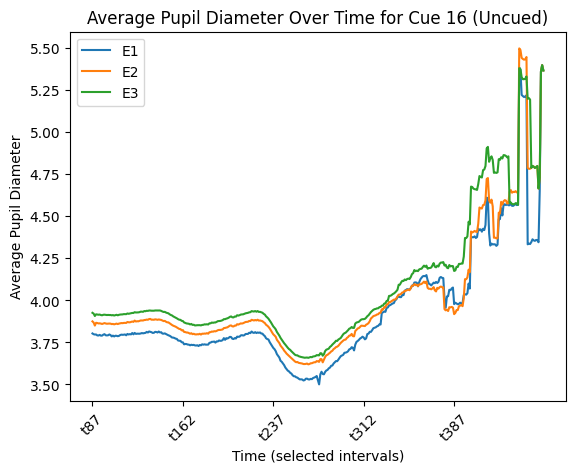

In [14]:
plot_pupil_diameter(averages, "cued")
plot_pupil_diameter(averages, "uncued")

##### Main Graph for Average pupil diameter over time 

In [15]:
import seaborn as sns

color_palette = sns.color_palette("husl", 12)
color_index = 0

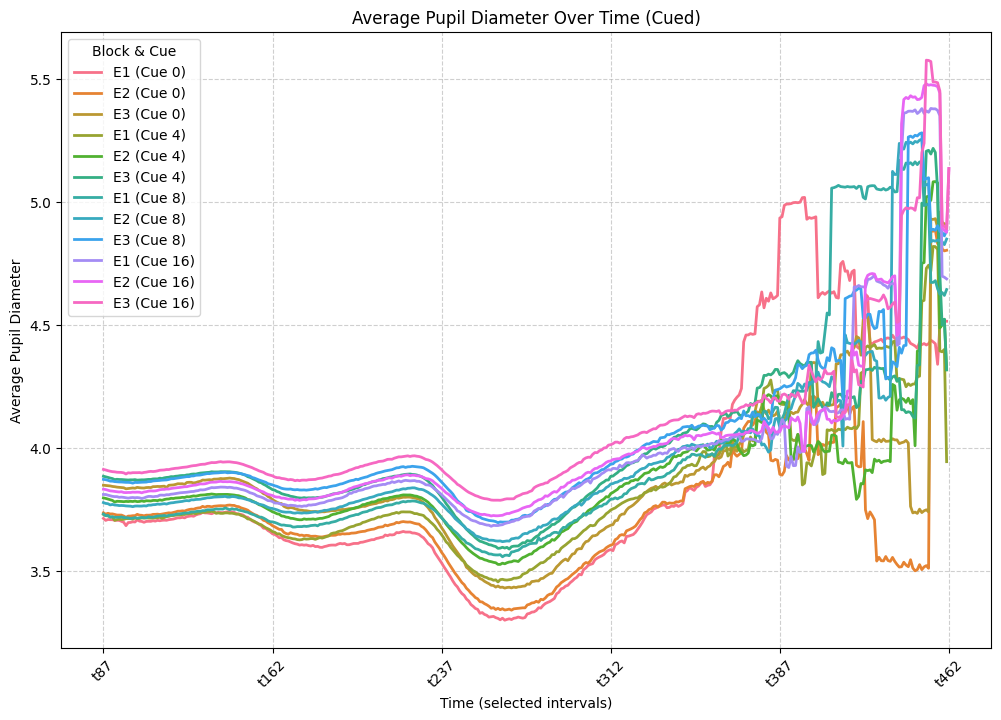

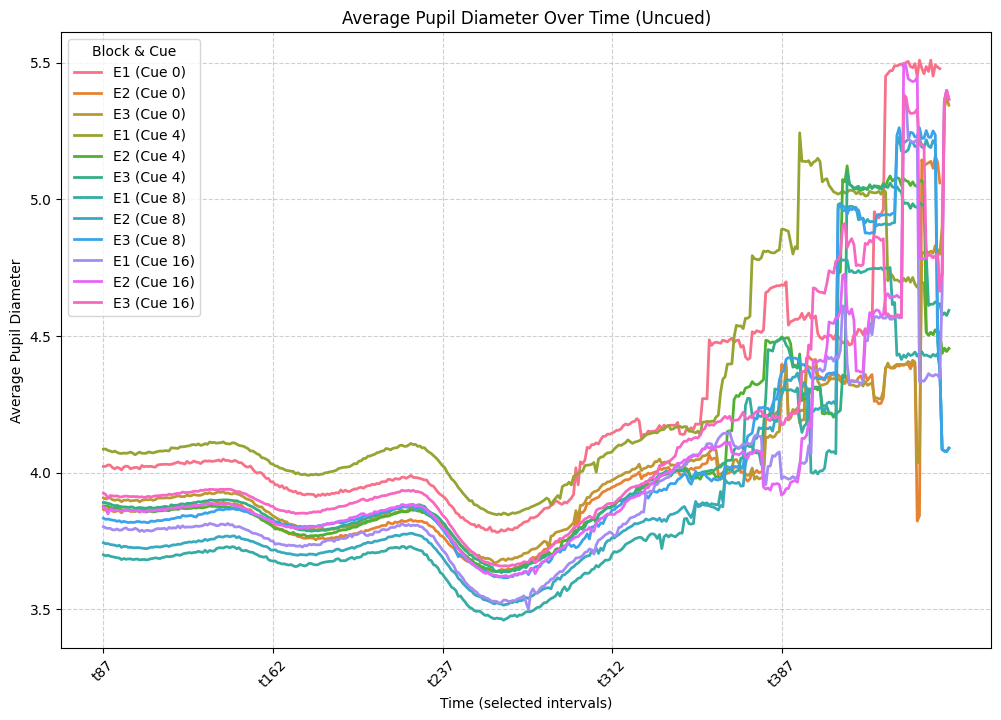

In [ ]:

for cue_type in ["cued", "uncued"]:
    plt.figure(figsize=(12, 8))
    color_index = 0 

    for group in ["0", "4", "8", "16"]:
        for block in ['E1', 'E2', 'E3']:
            key = f"{block}_{group}"
            if key in averages[cue_type]:
                avg_values = averages[cue_type][key]
                time_points = [col for col in avg_values.index if col.startswith('t')]

                x_ticks = list(range(0, len(time_points), max(1, len(time_points) // 5)))
                x_labels = [time_points[i] for i in x_ticks]

                plt.plot(time_points, avg_values[time_points],
                         label=f"{block} (Cue {group})",
                         color=color_palette[color_index],
                         linewidth=2)

                color_index = color_index + 1

    plt.xlabel("Time (selected intervals)")
    plt.ylabel("Average Pupil Diameter")
    plt.title(f"Average Pupil Diameter Over Time ({cue_type.capitalize()})")
    plt.xticks(x_ticks, x_labels, rotation=45)
    plt.legend(title="Block & Cue", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


This code calculates and stores median reaction times for each participant across different combinations of cue types (cued, uncued), emotions (from the emotions list), and eccentricity levels (0, 4, 8, 16). It loops through each participant’s folder, constructs the path to the relevant CSV file (e.g., Happy_4.csv under the respective cue and emotion), reads the file if it exists, extracts non-missing response_time values, computes the median, and appends it to a list. These lists of medians are then stored in a nested dictionary reaction_times, organized by cue type and emotion-eccentricity combination.

In [ ]:
reaction_times = {"cued": {}, "uncued": {}}
cue_types = ["cued", "uncued"]
eccentricity_groups = ["0", "4", "8", "16"]

for cue in cue_types:
    for blk in emotions:
        for group in eccentricity_groups:
            combo_key = f"{blk}_{group}"
            medians = []

            for person in os.listdir(base_dir):
                file_path = os.path.join(base_dir, person, blk, cue, f"{combo_key}.csv")
                
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)

                    if 'response_time' in df.columns:
                        rt_series = df['response_time'].dropna()
                        if not rt_series.empty:
                            medians.append(rt_series.median())

            if medians:
                reaction_times[cue][combo_key] = medians


In [ ]:
# reaction_times = compute_reaction_times(base_dir)

In [27]:
reaction_times

{'cued': {'E1_0': [0.3553698499890743,
   0.1984631000086665,
   0.0949157999712042,
   0.702368099999148,
   0.2349209999956656,
   0.3977532500284724,
   0.2257244000211358,
   0.2118218000014167,
   0.2993129000533372,
   0.1169424998806789],
  'E1_4': [0.2892442499869503,
   0.2583355000242591,
   0.18389454999123694,
   0.926575299999968,
   0.2548442500119563,
   0.4290555999614298,
   0.3977979999035597,
   0.2856993999994301,
   0.3214036000426858,
   0.10732660000212485],
  'E1_8': [0.3628283999860286,
   0.36319649999495596,
   0.10150114999851209,
   0.691855800001576,
   0.2599560999951791,
   0.6190655499813147,
   0.33958164998330176,
   0.2456268000005366,
   0.3620147000765428,
   0.14345234993379555],
  'E1_16': [0.3942521999997552,
   0.3396842000074684,
   0.1516255000024102,
   0.773049100000208,
   0.3225481000263244,
   0.588332699961029,
   0.4222473999252543,
   0.32025044999954844,
   0.4716868000105023,
   0.1520344999153167],
  'E2_0': [0.463573700049892,
   

Now in this we are plotiing boxplots of RT for each emotiom-eccentricity condition in separate fpr both cued and uncued. For each cue type, it creates a DataFrame of individual reaction time values grouped by condition (like Happy_4, Angry_8, etc.). Then visualized the distribution of these rt in boxplot

C:\Users\P.Harshvardhini\AppData\Local\Temp\ipykernel_20328\1330143795.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rt_df, x="Condition", y="Reaction Time", palette="Set2")


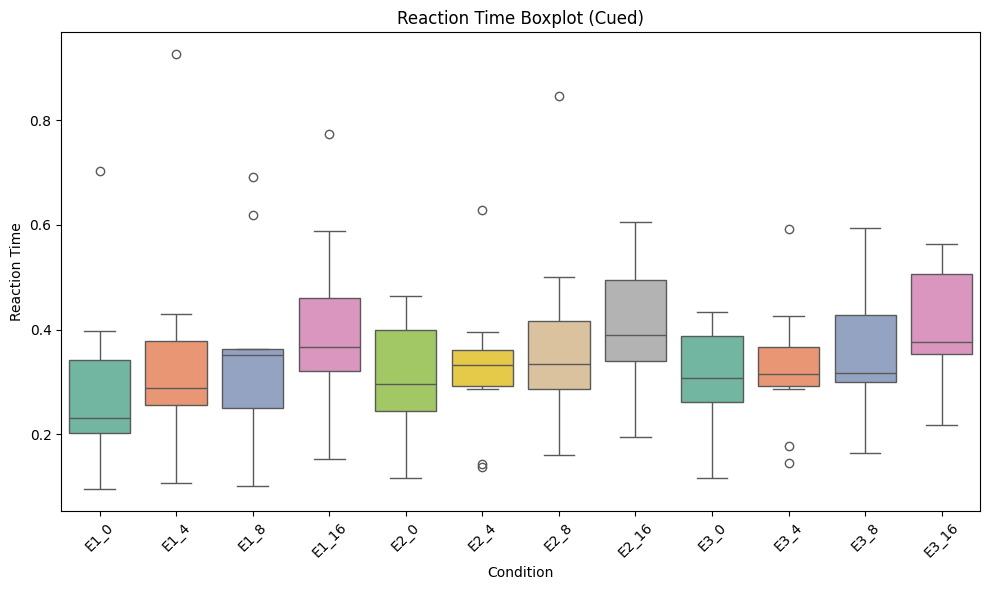

C:\Users\P.Harshvardhini\AppData\Local\Temp\ipykernel_20328\1330143795.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rt_df, x="Condition", y="Reaction Time", palette="Set2")


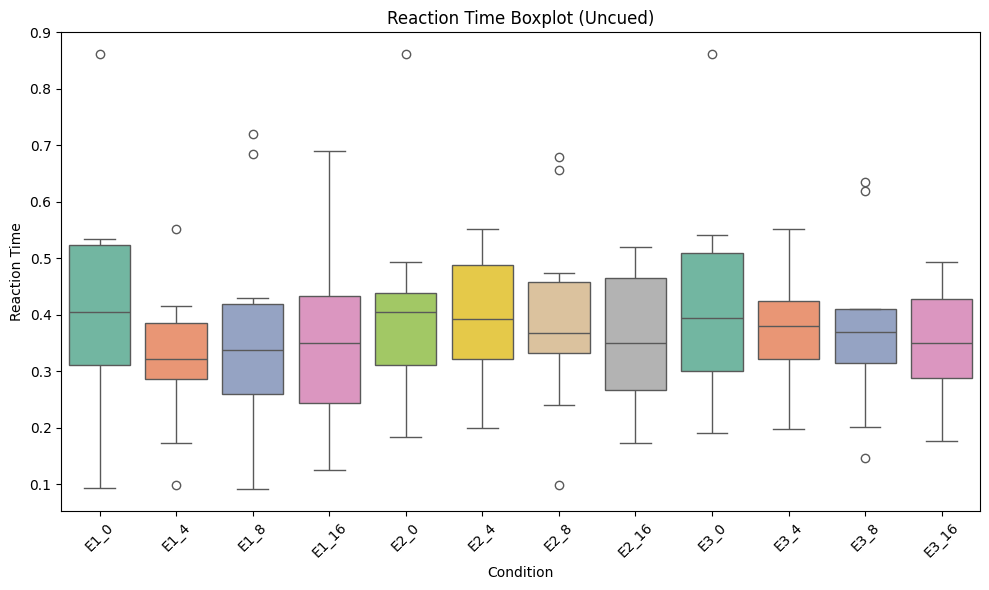

In [28]:
for cue in ["cued", "uncued"]:
    records = []

    for cond in reaction_times[cue]:
        for rt in reaction_times[cue][cond]:
            records.append({
                "Condition": cond,
                "Reaction Time": rt,
                "Cue Type": cue
            })

    rt_df = pd.DataFrame(records)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=rt_df, x="Condition", y="Reaction Time", palette="Set2")
    plt.xlabel("Condition")
    plt.ylabel("Reaction Time")
    plt.title(f"Reaction Time Boxplot ({cue.capitalize()})")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

THese below graphs are basically to visualize hoy reaction time changes as we incrase eccentricity. As in the above graph it is hard to visualize because it is small so i plotted like this.

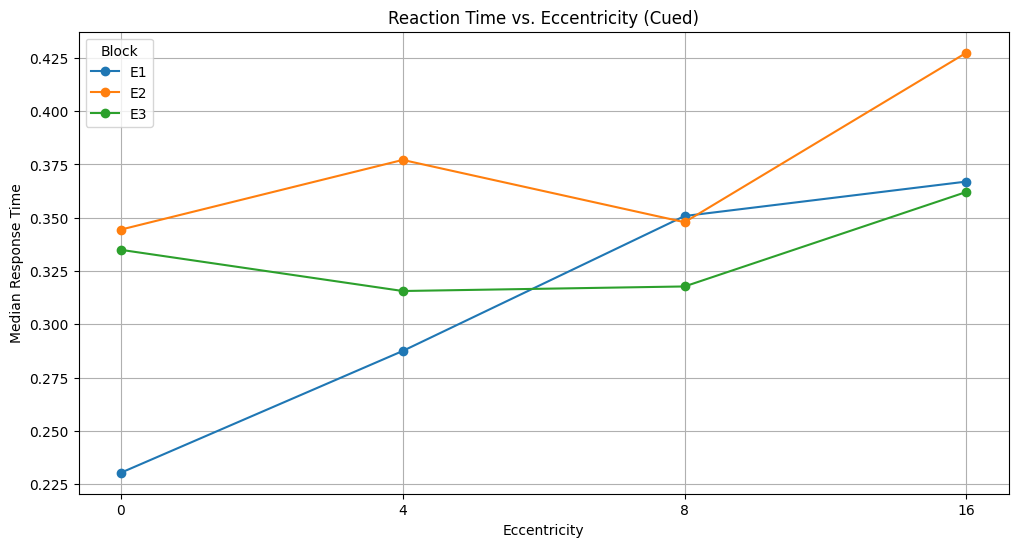

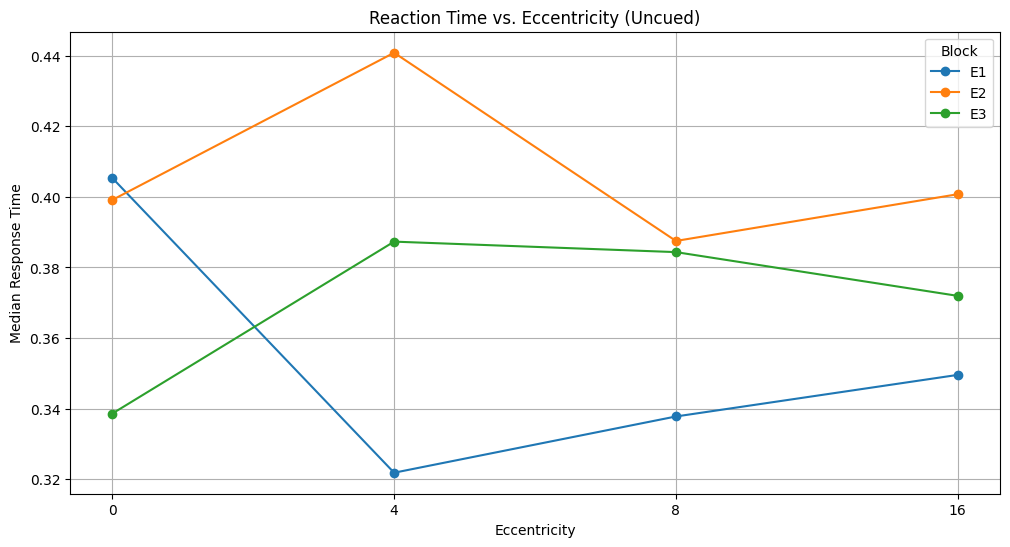

### Supporting plot

This plot is mainly about MAD (Median Absolute Deviation) to show variability. In this plot there is grpuped bar charts showing the median RT acreoss different eccentricities for each emotion type for both cued and uncued. The line shows the MAD

In [31]:
eccentricities = [0, 4, 8, 16]
x_vals = np.arange(len(eccentricities))
bar_width = 0.25

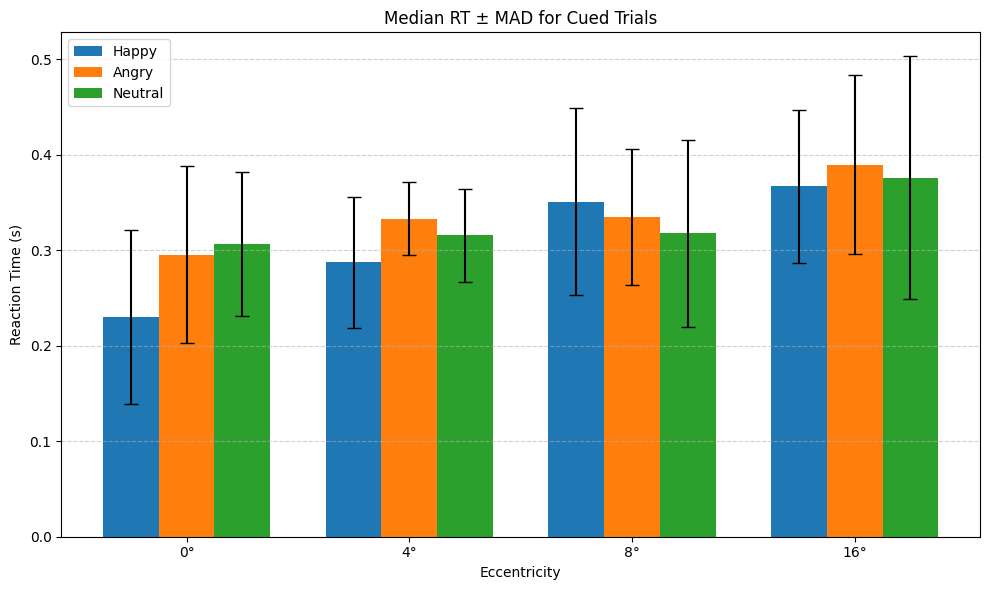

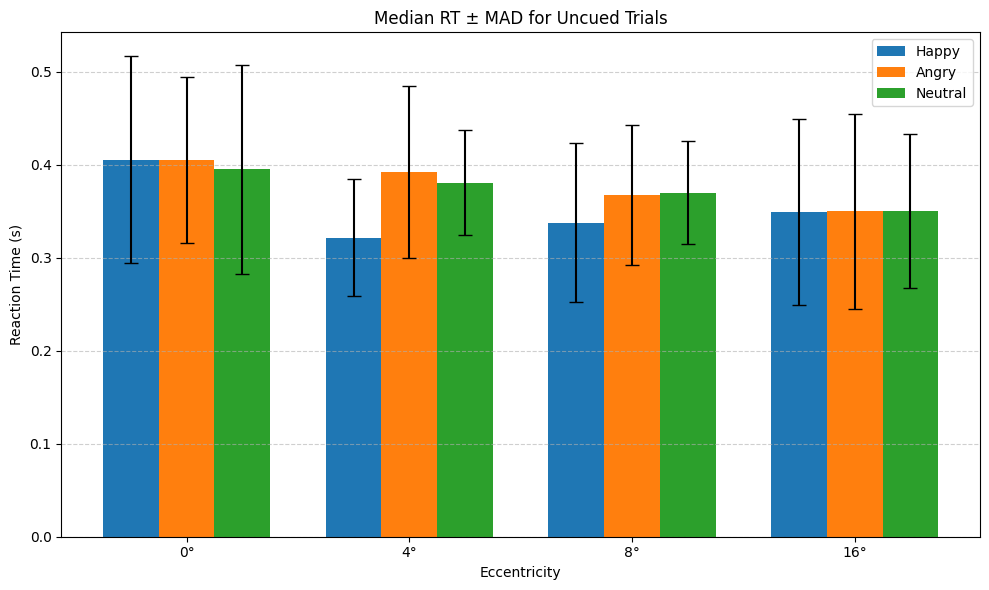

In [33]:
import matplotlib.pyplot as plt
import numpy as np

emotions = ['Happy', 'Angry', 'Neutral']
eccentricities = [0, 4, 8, 16]
x_vals = np.arange(len(eccentricities))
bar_width = 0.25

for cue in ['cued', 'uncued']:
    all_medians = {}
    all_mads = {}

    for i, emotion in enumerate(emotions):
        med_list = []
        mad_list = []

        for ecc in eccentricities:
            key = f"E{i+1}_{ecc}"
            if key in reaction_times[cue]:
                rt_vals = np.array(reaction_times[cue][key])
                med = np.median(rt_vals)
                mad = np.median(np.abs(rt_vals - med))
                med_list.append(med)
                mad_list.append(mad)
            else:
                med_list.append(np.nan)
                mad_list.append(np.nan)

        all_medians[emotion] = med_list
        all_mads[emotion] = mad_list

    plt.figure(figsize=(10, 6))

    for i, emotion in enumerate(emotions):
        x_pos = x_vals + i * bar_width
        plt.bar(x_pos, all_medians[emotion], 
                yerr=all_mads[emotion], 
                width=bar_width, 
                capsize=5, 
                label=emotion)

    plt.xticks(x_vals + bar_width, [f"{e}°" for e in eccentricities])
    plt.xlabel("Eccentricity")
    plt.ylabel("Reaction Time (s)")
    plt.title(f"Median RT ± MAD for {cue.capitalize()} Trials")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
